In [184]:
import pennylane as qml
import pennylane.numpy as np

# $\hat{V}_{QA}$

In [185]:
def prepare_Q(U, wires):
    """Prepares Q into the quantum state defined by the unitary U

    Args:
        U (array[complex]): the matrix U to apply to the fiduciary quantum state of Q
        wires (array[int]): the wires representing Q. If Q is a single-qubit, then this should be an array of length 1.
    """
    # Is this the correct way to prepare the Q state?
    qml.QubitUnitary(U, wires)

In [186]:
def prepare_V_QA(alpha, wires):
    """Prepares the V_QA parametric gate given the vector alpha for a Q with k=1 qubits

    Args:
        alpha (array[complex]): The alpha vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, and wires[1..2] shoudl represent A
    """
    # First two gates for each wire
    qml.RY(alpha[0], wires=wires[0])
    qml.RX(alpha[1], wires=wires[0])

    qml.RY(alpha[6], wires=wires[1])
    qml.RX(alpha[7], wires=wires[1])

    qml.RY(alpha[12], wires=wires[2])
    qml.RX(alpha[13], wires=wires[2])

    # Controlled on wire 0
    qml.CRX(alpha[8], wires=[wires[0], wires[1]])
    qml.CRX(alpha[14], wires=[wires[0], wires[2]])

    # Controlled on wire 1
    qml.CRX(alpha[2], wires=[wires[1], wires[0]])
    qml.CRX(alpha[15], wires=[wires[1], wires[2]])

    # Controlled on wire 2
    qml.CRX(alpha[3], wires=[wires[2], wires[0]])
    qml.CRX(alpha[9], wires=[wires[2], wires[1]])

    # Last two gates for each wire
    qml.RY(alpha[4], wires=wires[0])
    qml.RX(alpha[5], wires=wires[0])

    qml.RY(alpha[10], wires=wires[1])
    qml.RX(alpha[11], wires=wires[1])

    qml.RY(alpha[16], wires=wires[2])
    qml.RX(alpha[17], wires=wires[2])

# $\hat{W}_{QAB}$

In [187]:
def prepare_W_QAB(beta, wires):
    """Prepares the W_QAB parametric gate given the vector beta for a Q with k=1 qubits

    Args:
        beta (array[complex]): The beta vector containing the angles used for rotation in the Pauli operators
        wires (array[int]): The wires to act on. wires[0] should represent Q, wires[1..2] should represent A, and wires[3..4] should represent B
    """
    # First two gates for each wire
    qml.RY(beta[0], wires=wires[0])
    qml.RX(beta[1], wires=wires[0])

    qml.RY(beta[10], wires=wires[1])
    qml.RX(beta[11], wires=wires[1])

    qml.RY(beta[20], wires=wires[2])
    qml.RX(beta[21], wires=wires[2])

    qml.RY(beta[30], wires=wires[3])
    qml.RX(beta[31], wires=wires[3])

    qml.RY(beta[34], wires=wires[4])
    qml.RX(beta[35], wires=wires[4])

    # Controlled on wire 3
    qml.CRX(beta[2], wires=[wires[3], wires[0]])
    qml.CRZ(beta[3], wires=[wires[3], wires[0]])

    qml.CRX(beta[12], wires=[wires[3], wires[1]])
    qml.CRZ(beta[13], wires=[wires[3], wires[1]])

    qml.CRX(beta[22], wires=[wires[3], wires[2]])
    qml.CRZ(beta[23], wires=[wires[3], wires[2]])

    # Controlled on wire 4
    qml.CRX(beta[4], wires=[wires[4], wires[0]])
    qml.CRZ(beta[5], wires=[wires[4], wires[0]])

    qml.CRX(beta[14], wires=[wires[4], wires[1]])
    qml.CRZ(beta[15], wires=[wires[4], wires[1]])

    qml.CRX(beta[24], wires=[wires[4], wires[2]])
    qml.CRZ(beta[25], wires=[wires[4], wires[2]])

    # Middle rotation gates for each wire
    qml.RY(beta[6], wires=wires[0])
    qml.RX(beta[7], wires=wires[0])

    qml.RY(beta[16], wires=wires[1])
    qml.RX(beta[17], wires=wires[1])

    qml.RY(beta[26], wires=wires[2])
    qml.RX(beta[27], wires=wires[2])

    qml.RY(beta[22], wires=wires[3])
    qml.RX(beta[23], wires=wires[3])

    qml.RY(beta[36], wires=wires[4])
    qml.RX(beta[37], wires=wires[4])

    # Controlled to apply on wire 0
    qml.ctrl(qml.RZ(beta[8], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])
    qml.ctrl(qml.RX(beta[9], wires=wires[0]), control=[wires[3], wires[4]], control_values=[1, 0])

    # Controlled to apply on wire 1
    qml.ctrl(qml.RZ(beta[18], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])
    qml.ctrl(qml.RX(beta[19], wires=wires[1]), control=[wires[3], wires[4]], control_values=[1, 1])

    # Controlled to apply on wire 2
    qml.ctrl(qml.RZ(beta[28], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])
    qml.ctrl(qml.RX(beta[29], wires=wires[2]), control=[wires[3], wires[4]], control_values=[0, 1])

### Logic diagram of $\hat{V}_{QA}$ and $\hat{W}_{QAB}$

In [188]:
alpha_length = 18
beta_length = 38
test_alpha = np.random.uniform(0, np.pi, size=(alpha_length,))
test_beta = np.random.uniform(0, np.pi, size=(beta_length,))

In [189]:
Q_wires= [0]
A_wires = [1,2]
B_wires = [3,4]
dev = qml.device('default.mixed', wires=len(Q_wires) + len(A_wires) + len(B_wires))

@qml.qnode(dev)
def test_V_QA(alpha):
    prepare_V_QA(alpha, Q_wires + A_wires)
    return qml.state()

@qml.qnode(dev)
def test_W_QAB(beta):
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    return qml.state()

(<Figure size 1300x400 with 1 Axes>, <Axes: >)

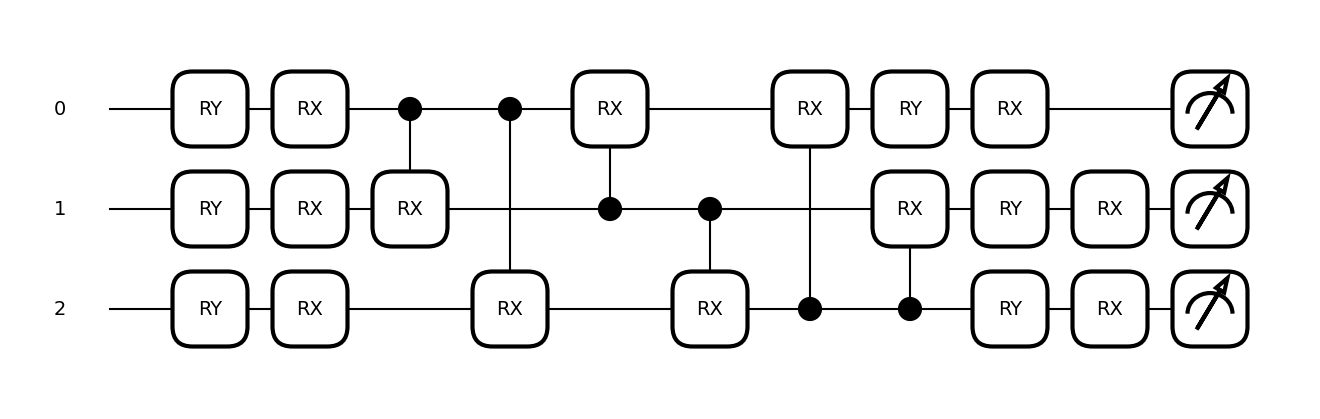

In [190]:
qml.draw_mpl(test_V_QA)(test_alpha)

(<Figure size 2500x600 with 1 Axes>, <Axes: >)

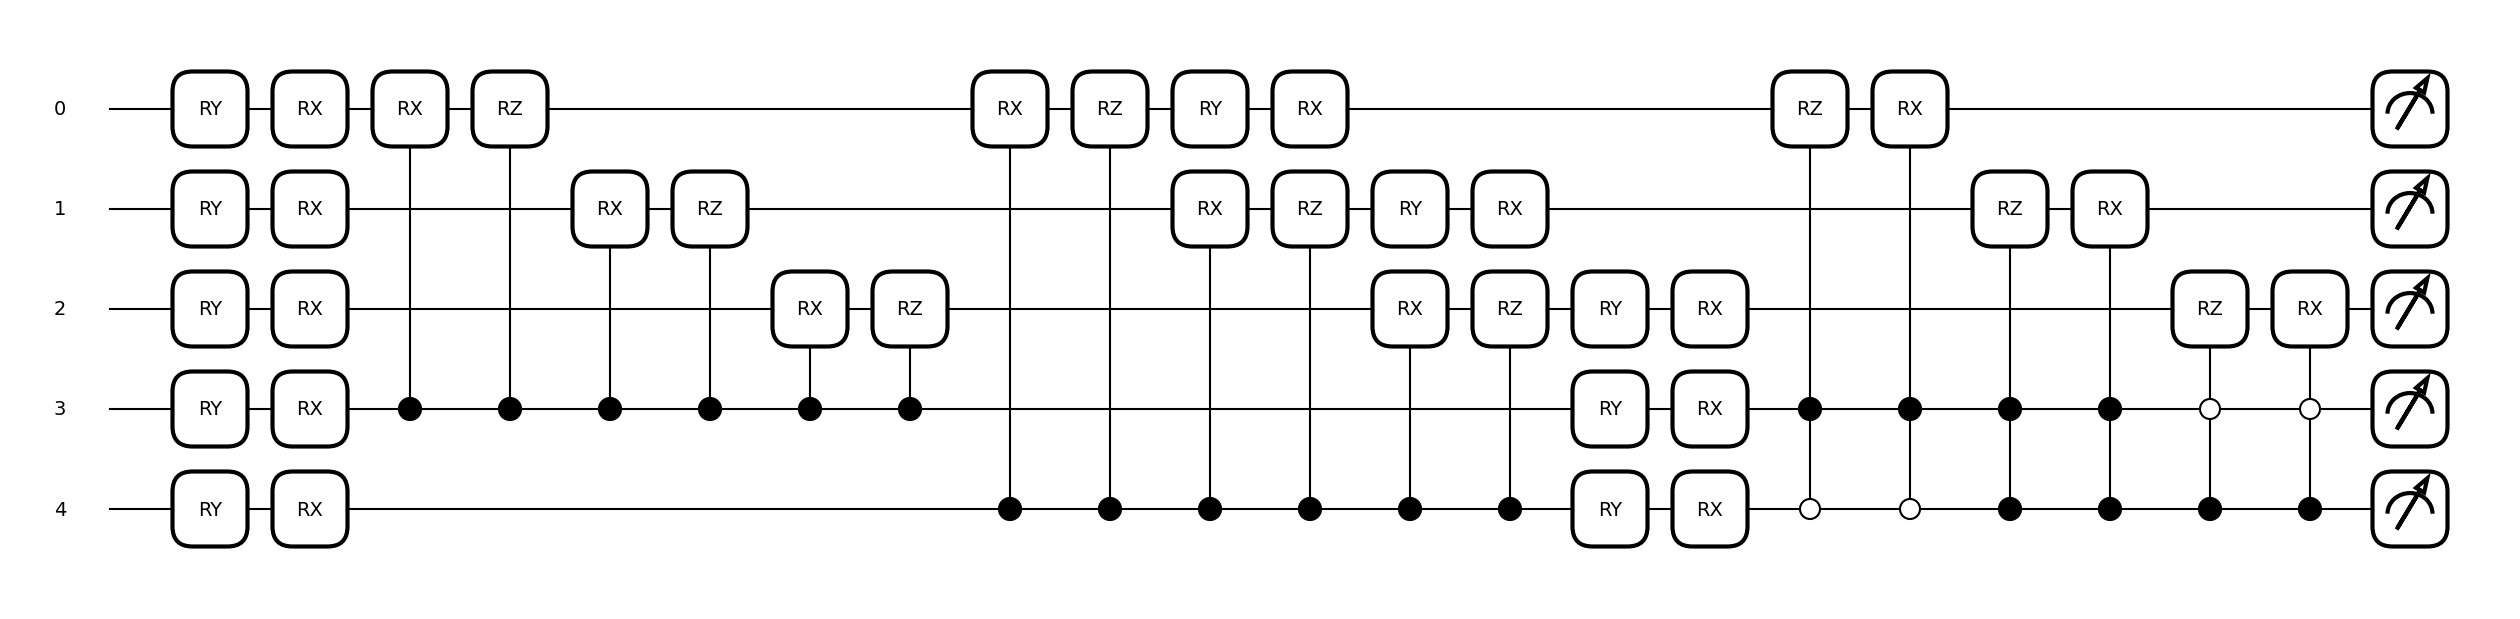

In [191]:
qml.draw_mpl(test_W_QAB)(test_beta)

# Constants

In [192]:
bitflip_probability = 0.5
phaseflip_probability = 0.1

Q_qubits = 1
A_qubits = 2
B_qubits = 2

Q_wires = list(range(Q_qubits))
A_wires = list(range(Q_qubits, Q_qubits + A_qubits))
B_wires = list(range(Q_qubits + A_qubits, Q_qubits + A_qubits + B_qubits))

dim = 2 ** (Q_qubits + A_qubits)

# Gradient Descent 
stepsize = 0.01
momentum = 0.95

# Number of iterations
num_its = 500

# Unitary matrix to test
U = qml.T.compute_matrix()

# Calculate Hamiltonians for Fidelity and Wasserstein

In [193]:
dev = qml.device('default.mixed', wires=Q_qubits + A_qubits + B_qubits)

# Get the fidelity hamiltonian matrix from the 0 state
@qml.qnode(dev)
def fiduciary_density(wires):
    return qml.density_matrix(wires)

#Calculate the hamiltonian for the fiduciary cost
H_QA_fid = np.identity(dim) - fiduciary_density(Q_wires + A_wires)

def wass_hamiltonian():
    H_wass = np.zeros((dim, dim))
    for i in range (1, dim):
        vec = np.zeros((dim, 1))
        vec[i, 0] = 1
        
        # Binary 011, 101, 110
        if i == 3 or i == 5 or i == 6:
            density_mat = 2 * np.outer(vec, vec.T)
        # Binary 111
        elif i == 7:
            density_mat = 3 * np.outer(vec, vec.T)
        # Binary 001, 010, 100
        else:
            density_mat = np.outer(vec, vec.T)
            
        H_wass += density_mat
    return H_wass

H_QA_wass = wass_hamiltonian()

# Implementation of the VQA with bitflip noise

In [194]:
@qml.qnode(dev)
def VQA_bitflip_noise_fid(U, alpha, beta):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise
    qml.BitFlip(bitflip_probability, wires=Q_wires)
    qml.BitFlip(bitflip_probability, wires=A_wires[0])
    qml.BitFlip(bitflip_probability, wires=A_wires[1])
    
    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)

    return qml.expval(qml.Hermitian(H_QA_fid, wires=[0,1,2]))

@qml.qnode(dev)
def VQA_bitflip_noise_wass(U, alpha, beta):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise
    qml.BitFlip(bitflip_probability, wires=Q_wires)
    qml.BitFlip(bitflip_probability, wires=A_wires[0])
    qml.BitFlip(bitflip_probability, wires=A_wires[1])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)
    
    return qml.expval(qml.Hermitian(H_QA_wass, wires=[0,1,2]))

Test fidelity function

In [195]:
VQA_bitflip_noise_fid(U, test_alpha, test_beta)

array(0.91979874)

Draw fidelity circuit

(<Figure size 4800x600 with 1 Axes>, <Axes: >)

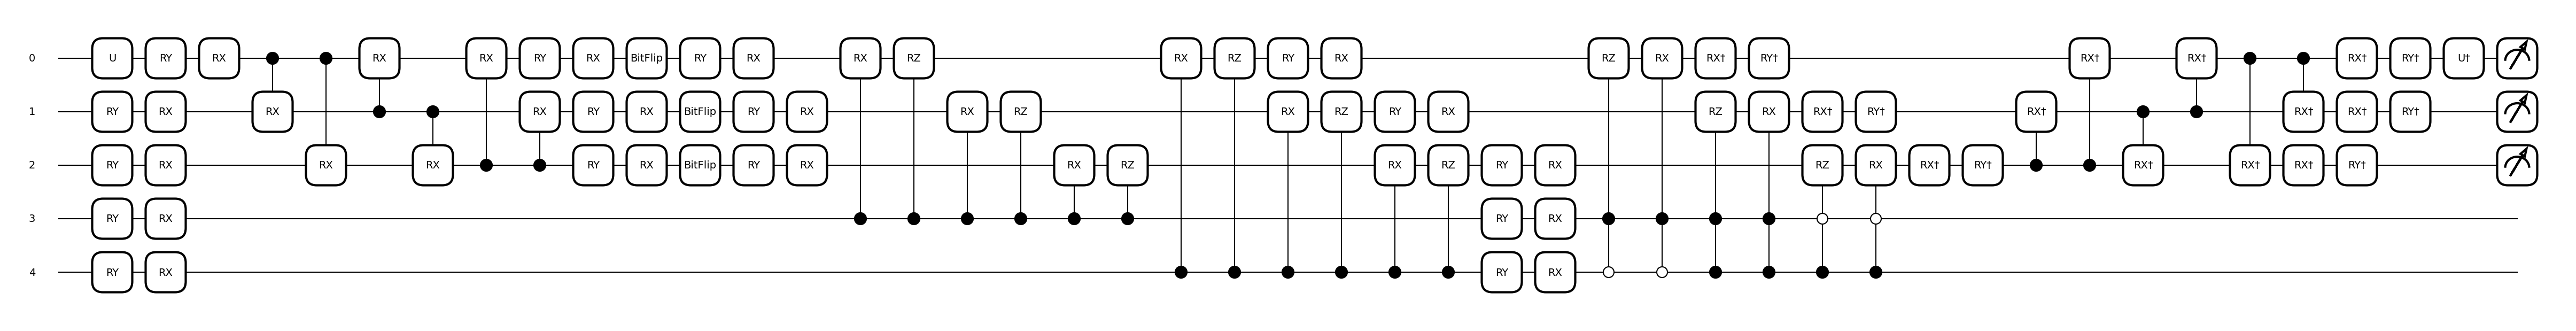

In [196]:
qml.draw_mpl(VQA_bitflip_noise_fid)(U, test_alpha, test_beta)

# Implementation of VQA with Phase Flip Noise

In [197]:
@qml.qnode(dev)
def VQA_phaseflip_noise_fid(U, alpha, beta):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise
    qml.PhaseFlip(phaseflip_probability, wires=Q_wires)
    qml.PhaseFlip(phaseflip_probability, wires=A_wires[0])
    qml.PhaseFlip(phaseflip_probability, wires=A_wires[1])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)

    return qml.expval(qml.Hermitian(H_QA_fid, wires=[0,1,2]))

@qml.qnode(dev)
def VQA_phaseflip_noise_wass(U, alpha, beta):
    prepare_Q(U, Q_wires)
    prepare_V_QA(alpha, Q_wires + A_wires)

    # Insert noise
    qml.PhaseFlip(phaseflip_probability, wires=Q_wires)
    qml.PhaseFlip(phaseflip_probability, wires=A_wires[0])
    qml.PhaseFlip(phaseflip_probability, wires=A_wires[1])

    prepare_W_QAB(beta, Q_wires + A_wires + B_wires)
    qml.adjoint(prepare_V_QA)(alpha, Q_wires + A_wires)
    qml.adjoint(prepare_Q)(U, Q_wires)

    return qml.expval(qml.Hermitian(H_QA_wass, wires=[0,1,2]))

Test Fidelity function

In [198]:
VQA_phaseflip_noise_fid(U, test_alpha, test_beta)

array(0.93511691)

Draw fidelity function

(<Figure size 4800x600 with 1 Axes>, <Axes: >)

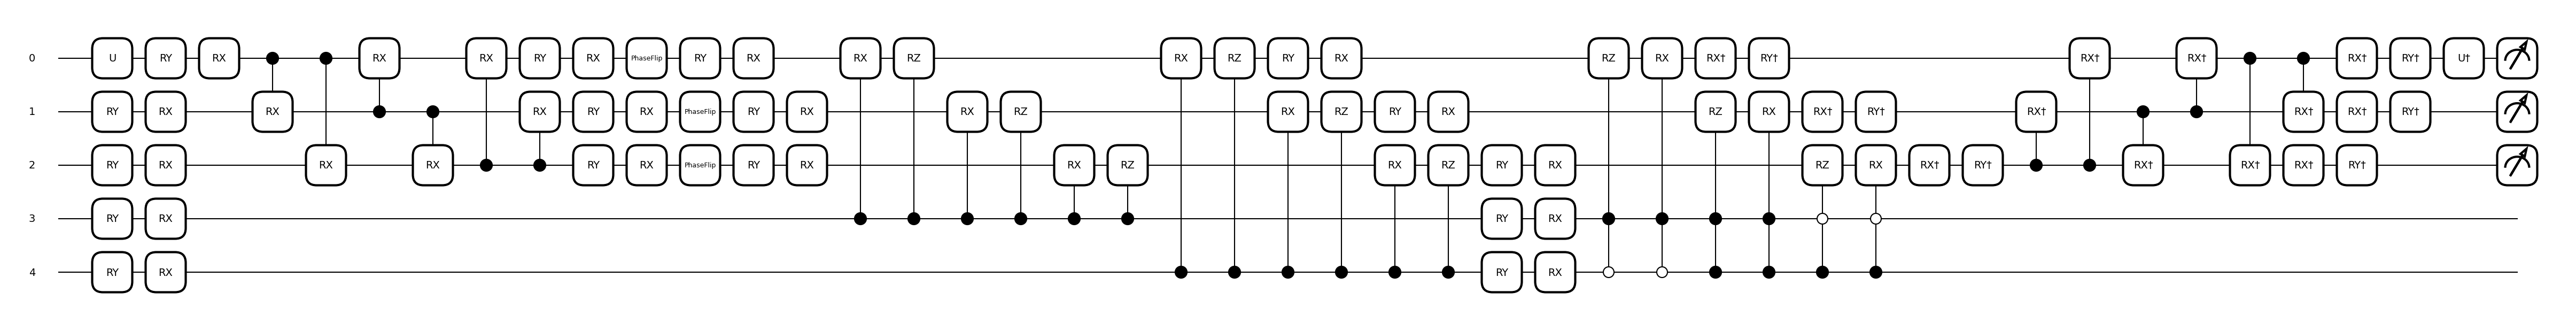

In [199]:
qml.draw_mpl(VQA_phaseflip_noise_fid)(U, test_alpha, test_beta)

# Cost Function (Fidelity)

In [200]:
def fidelity_cost_bitflip_noise(U):
    # Wasn't sure if I was supposed to get the density matrix at the end of the circuit, or after applying W and before the adjoints
    # Based off my understanding of the paper and eq. 4, I think it should be at the end as is, but may want to look at this assumption again
    
    def compute_cost(alpha, beta):
        # Matrix multiply, or tensor product? Also had to abs value it, or else it would complain we can't do grad descent on imaginary numbers
        return VQA_bitflip_noise_fid(U, alpha, beta)

    return compute_cost

In [201]:
def wasserstein_cost_bitflip_noise(U):
    def compute_cost(alpha, beta):
        return VQA_bitflip_noise_wass(U, alpha, beta)
    
    return compute_cost

Test with test values

In [202]:
fidelity_cost_bitflip_noise(U)(test_alpha, test_beta)

array(0.91979874)

In [203]:
wasserstein_cost_bitflip_noise(U)(test_alpha, test_beta)

array(1.58356803)

Now we can use `fidelity_cost_bitflip_noise()` and perform gradient descent

In [204]:
alpha = test_alpha # arbitrary
beta = test_beta # arbitrary

test_U = U # use the previous U we've been using in our tests

opt = qml.MomentumOptimizer(stepsize, momentum)

running_costs = []

for _ in range(num_its):
    (alpha, beta), _cost = opt.step_and_cost(fidelity_cost_bitflip_noise(test_U), alpha, beta)
    running_costs.append(_cost)

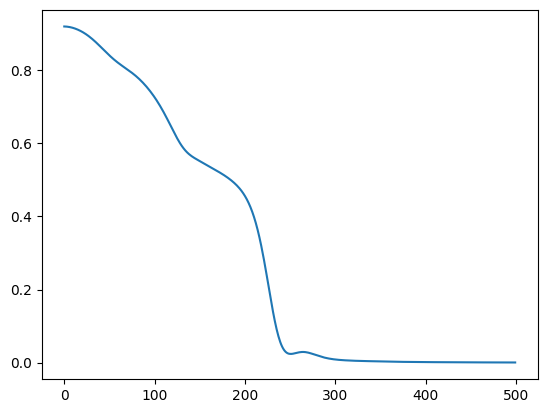

In [205]:
import matplotlib.pyplot as plt

plt.plot(running_costs)

In [206]:
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: [ 1.56137680e+00  1.32270187e+00  9.20709675e-01  8.10365639e-01
  2.31345179e-03  1.99022991e+00  1.68317991e+00  1.23088367e+00
 -1.83518787e-02  3.11421670e+00  2.08091419e+00  1.93281760e+00
  3.32295171e+00  5.11797902e-01  3.90160787e-03  2.15567832e+00
  4.15647453e-02  1.25901802e+00]
Beta: [ 1.32969561e+00  2.98137826e+00  1.06160859e+00  2.09247984e+00
  1.69846981e+00  4.03231130e+00  2.61548172e+00  7.19607501e-01
 -1.77254605e-02  1.43322757e+00  1.20200231e+00  2.83238969e+00
  1.57093415e+00  1.07271928e+00  2.57138413e+00  3.16615063e+00
  3.36191640e+00  1.91856708e+00  1.25574602e-01  2.13965113e+00
  1.18814892e+00  1.47328459e+00  3.52054249e+00  2.73662638e+00
  1.93674141e+00  1.45624993e+00  1.46435787e+00  5.51042874e-01
  3.64131658e-02  2.75831219e+00 -2.76565170e-03  3.17639487e+00
  1.37021509e-01  1.53413787e+00  5.50824575e-04  3.15489354e+00
  3.19866104e-01  6.94895226e-01]


Now we can use `wasserstein_cost_bitflip_noise()` and perform gradient descent

In [207]:
alpha = test_alpha # arbitrary
beta = test_beta # arbitrary

test_U = U # use the previous U we've been using in our tests

opt = qml.MomentumOptimizer(stepsize, momentum)

running_costs = []

for _ in range(num_its):
    (alpha, beta), _cost = opt.step_and_cost(wasserstein_cost_bitflip_noise(test_U), alpha, beta)
    running_costs.append(_cost)

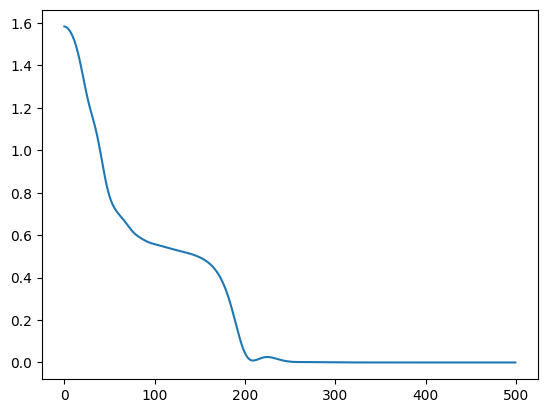

In [208]:
import matplotlib.pyplot as plt

plt.plot(running_costs)

In [209]:
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: [ 1.61533162e+00  7.90929675e-01  3.76599921e-01  3.82993125e-01
 -3.40802273e-02  2.27166092e+00  1.59144223e+00  1.26801468e+00
  9.10131745e-02  3.14221788e+00  2.07001677e+00  2.01414776e+00
  3.23291323e+00  4.93120547e-01  2.42888292e-03  2.15883708e+00
  4.01240918e-03  1.15980301e+00]
Beta: [ 1.25425376e+00  2.89151500e+00  1.01866421e+00  1.92138906e+00
  1.78149354e+00  4.12774708e+00  2.76969488e+00  4.56884832e-01
 -3.73232070e-03  1.26139561e+00  9.45277491e-01  2.88980888e+00
  1.61477689e+00  1.28655618e+00  2.33069828e+00  3.50759934e+00
  3.00940831e+00  1.98585601e+00  1.37798058e-03  1.85630626e+00
  1.24011437e+00  1.46891675e+00  3.26360017e+00  2.81112962e+00
  1.88760814e+00  1.56452161e+00  1.27071508e+00  6.75998818e-01
  4.77383041e-02  2.67903368e+00  8.17209124e-04  3.14571548e+00
  1.37021509e-01  1.53413787e+00 -4.50288924e-04  3.14088795e+00
  4.38338770e-01  7.23815167e-01]
